# Twitter Sentiment Analysis

## Access to Drive

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library 

In [43]:
!pip install vowpalwabbit

In [44]:
import os

from os.path import join

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm as tn

import random
import spacy
import re

from vowpalwabbit.dftovw import DFtoVW
from vowpalwabbit import Workspace
from sklearn.preprocessing import MultiLabelBinarizer
from vowpalwabbit import pyvw

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from yellowbrick.text import TSNEVisualizer
from yellowbrick.text.tsne import tsne


## Tweet Data Acqusitiion and visualization

In [115]:
train_path = '/content/drive/MyDrive/AnimalFace/Twitter/twitter_training.csv'
valid_path = '/content/drive/MyDrive/AnimalFace/Twitter/twitter_validation.csv'
cols = ['Id', 'Entity', 'Sentiment', 'Tweet']
train = pd.read_csv(train_path, names = cols, header=None)
valid = pd.read_csv(valid_path, names = cols)
train['is_train'], valid['is_train'] = True, False
all_dataframe = train.append(valid)
all_dataframe

,Id,Entity,Sentiment,Tweet,is_train
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,True
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,True
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,True
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,True
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,True
...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,False
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,False
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,False
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,False


In [116]:
all_dataframe.index = pd.RangeIndex(len(all_dataframe.index))
all_dataframe.index = range(len(all_dataframe.index))
all_dataframe

,Id,Entity,Sentiment,Tweet,is_train
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,True
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,True
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,True
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,True
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,True
...,...,...,...,...,...
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,False
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,False
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,False
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,False


##  Exploratory Data Analysis (EDA)

In [117]:
all_dataframe.head(2).T

,0,1
Id,2401,2401
Entity,Borderlands,Borderlands
Sentiment,Positive,Positive
Tweet,im getting on borderlands and i will murder yo...,I am coming to the borders and I will kill you...
is_train,True,True


In [118]:
labeled_dataframe = train[['Sentiment', 'Tweet']].copy()#'Entity'

labeled_dataframe  = labeled_dataframe[pd.notnull(labeled_dataframe['Tweet'])]

labeled_dataframe.shape

(73996, 2)

In [119]:
labeled_dataframe.isnull().sum()

Sentiment    0
Tweet        0
dtype: int64

In [120]:
total = train['Tweet'].notnull().sum()
round((total/len(all_dataframe)*100),1)

97.8

In [121]:
# pd.DataFrame(short_dataframe.Sentiment.unique()).values
labeled_dataframe.Sentiment.value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: Sentiment, dtype: int64

In [122]:
labeled_dataframe['Sentiment_target'] = labeled_dataframe.Sentiment.factorize()[0]
# short_dataframe=short_dataframe[['Tweet', 'Sentiment_target']].drop_duplicates()
short_dataframe = labeled_dataframe.sample(30000, random_state=1).copy()
short_dataframe

,Sentiment,Tweet,Sentiment_target
56570,Positive,Are we just going to pretend to be @ Ubisoft a...,0
54194,Negative,"The problem is even more than racism, it's a d...",2
64054,Negative,Hey @EAMaddenNFL but when else is the update c...,2
42756,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
38295,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
14506,Negative,The Wtf??,2
25689,Negative,ive had enough and this sexist bullshit,2
20759,Neutral,"I, then, humbly conclude, a toast, with Nikola...",1
50802,Negative,This proof where we are under these organizati...,2


In [123]:
short_dataframe=short_dataframe.drop_duplicates()
short_dataframe

,Sentiment,Tweet,Sentiment_target
56570,Positive,Are we just going to pretend to be @ Ubisoft a...,0
54194,Negative,"The problem is even more than racism, it's a d...",2
64054,Negative,Hey @EAMaddenNFL but when else is the update c...,2
42756,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
38295,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
14506,Negative,The Wtf??,2
25689,Negative,ive had enough and this sexist bullshit,2
20759,Neutral,"I, then, humbly conclude, a toast, with Nikola...",1
50802,Negative,This proof where we are under these organizati...,2


In [124]:
short_dataframe = short_dataframe.reset_index(drop=True)
short_dataframe

,Sentiment,Tweet,Sentiment_target
0,Positive,Are we just going to pretend to be @ Ubisoft a...,0
1,Negative,"The problem is even more than racism, it's a d...",2
2,Negative,Hey @EAMaddenNFL but when else is the update c...,2
3,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,3
4,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
28954,Negative,The Wtf??,2
28955,Negative,ive had enough and this sexist bullshit,2
28956,Neutral,"I, then, humbly conclude, a toast, with Nikola...",1
28957,Negative,This proof where we are under these organizati...,2


In [125]:
np.nonzero((short_dataframe.Sentiment_target==3).values)

(array([    3,     7,    13, ..., 28943, 28945, 28948]),)

In [126]:
for i in np.nonzero((short_dataframe.Sentiment_target==3).values):
    short_dataframe.Sentiment_target[i] = int(1)
short_dataframe.Sentiment_target.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    12196
2     8737
0     8026
Name: Sentiment_target, dtype: int64

As we can see in below graphs that the postive sentiments are more than negative and neutral sentiments

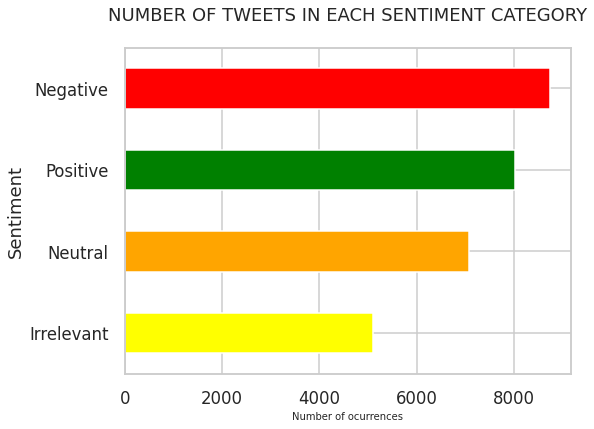

In [127]:
fig = plt.figure(figsize=(8,6))
colors = ['Yellow','orange','green', 'red']
short_dataframe.groupby(['Sentiment']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH SENTIMENT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

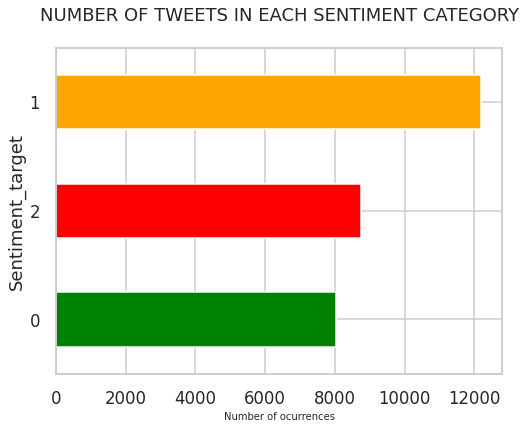

In [128]:
fig = plt.figure(figsize=(8,6))
colors = ['green', 'red', 'orange']
short_dataframe.groupby(['Sentiment_target']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH SENTIMENT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

This word cloud presents the most used words in the tweets

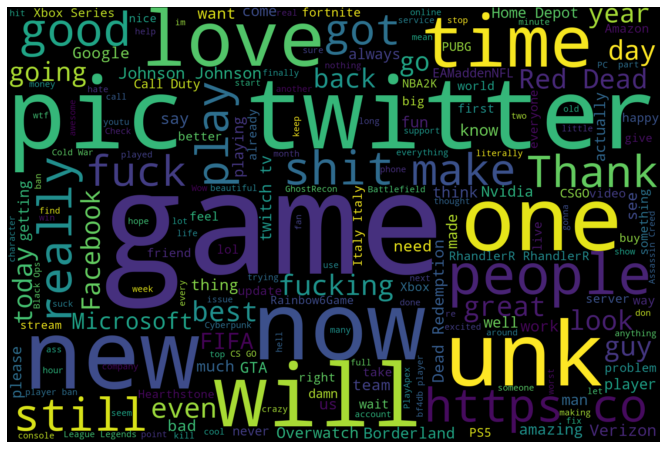

In [129]:
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black", width=1500, height=1000).generate(' '.join(short_dataframe['Tweet']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Cleaning and Preprocessing
in this we will remove the punctuation and other unrequired characters from our tweets

### Remove punctuation

In [60]:
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('\s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent


## Stop words removal with NLTK

In [62]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
def nltk_text_filter(text):
    word_tokens = word_tokenize(text) 
    
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [64]:
short_dataframe['Tweet']

0        Are we just going to pretend to be @ Ubisoft a...
1        The problem is even more than racism, it's a d...
2        Hey @EAMaddenNFL but when else is the update c...
3        Can Mingyu also play PUBG huhuhu I want him to...
4        @BlizzardCSEU_EN Any logical reason why my hea...
                               ...                        
28954                                            The Wtf??
28955              ive had enough and this sexist bullshit
28956    I, then, humbly conclude, a toast, with Nikola...
28957    This proof where we are under these organizati...
28958    @FallGuysGame Your game has some cool pontenti...
Name: Tweet, Length: 28959, dtype: object

## Stop words removal and lemmatization with SpaCy

In [66]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = English()

In [67]:
def spacy_text_filter(text):
    my_doc = nlp(text)
    
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
        
    filtered_sentence =[] 
    
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return ' '.join(filtered_sentence)

## Stopword Removal using Gensim

In [69]:
from gensim.parsing.preprocessing import remove_stopwords

## Vowpal Wabbit

In [71]:
short_dataframe.dtypes

Sentiment           object
Tweet               object
Sentiment_target     int64
dtype: object

In [72]:
converter = DFtoVW.from_colnames(df=short_dataframe, y='Sentiment_target', x='Tweet')
examples = converter.convert_dataframe()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/vowpalwabbit/dftovw.py:54: UserWarning: Name 'Shit freak wild dab' was not a valid feature/namespace name. It has been renamed 'Shit_freak_wild_dab'
  valid_name=valid_name,
/usr/local/lib/python3.7/dist-packages/vowpalwabbit/dftovw.py:54: UserWarning: Name '@ amazon is probably one of the worst customer services I've had to deal with lately' was not a valid feature/namespace name. It has been renamed '@_amazon_is_probably_one_of_the_worst_customer_services_I've_had_to_deal_with_lately'
  valid_name=valid_name,
/usr/local/lib/python3.7/dist-packages/vowpalwabbit/dftovw.py:54: UserWarning: Name 'Are we more surprised us anymore? EA at this point isn ’ about t scared off of the controversy that they already embrace about it..... EA Causes Outrage... by Advertising Advertising FIFA Microtransactions to Kids - Push Square pushsquare. com / news / 2020 / 09 / e … via Editor @GoogleNews' was not a valid

In [73]:
examples[:5]

["0 | Tweet=Are_we_just_going_to_pretend_to_be_@_Ubisoft_and_not_forget_what_they're_doing..._You're_driving_Ubisoft,_we're_waiting!!.",
 "2 | Tweet=The_problem_is_even_more_than_racism,_it's_a_direct_abuse_of_power_to_find_any_good_reason_to_use_force_or_hurt_someone,_it's_like_they're_really_having_fun,_how_many_of_these_cunning_gun-wielding_people_have_actually_seen_a_real_fight?",
 '2 | Tweet=Hey_@EAMaddenNFL_but_when_else_is_the_update_coming?_A_lot_of_glitches_occur_in_my_Twitter_game_so_far.',
 '1 | Tweet=Can_Mingyu_also_play_PUBG_huhuhu_I_want_him_to_have_polaroids_too_._🥺_it’s_really_cute__<',
 "2 | Tweet=@BlizzardCSEU_EN_Any_logical_reason_why_my_hearthstone's_broken?_It's_doing_nothing_(nor_could_only_one)"]

## Data Transformation ,Model Configuration and Training

In [74]:
model = Workspace(P=1, enable_logging=True)

for ex in examples:
    model.learn(ex)

model.finish()

In [75]:
model.get_log()[:20]

['using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'Enabled reductions: gd, scorer-identity, count_label',
 'Input label = simple',
 'Output pred = scalar',
 'average  since         example        example        current        current  current',
 'loss     last          counter         weight          label        predict features',
 '0.000000 0.000000            1            1.0         0.0000         0.0000        2',
 '2.000000 4.000000            2            2.0         2.0000         0.0000        2',
 '2.299217 2.897652            3            3.0         2.0000         0.2978        2',
 '1.788975 0.258249            4            4.0         1.0000         0.4918        2',
 '1.858964 2.138921            5            5.0         2.0000         0.5375        2',
 '1.626228 0.462545            6            6.0         0.0000         0.6801        2',
 '1.664760 1.895951          

In [76]:
model.get_log()[-10:]

['0.583266 0.978189        28959        28959.0         0.0000         0.9890        2',
 '',
 'finished run',
 'number of examples = 28959',
 'weighted example sum = 28959.000000',
 'weighted label sum = 29670.000000',
 'average loss = 0.583266',
 'best constant = 1.024552',
 'total feature number = 57914',
 '']

## tr2

In [77]:
X = short_dataframe['Tweet'] 
y = short_dataframe['Sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [78]:
# Convert to Vowpal Wabbit Format
def make_example(index):
    example_string = ""
    for i in range(y.shape[1]):
        # cost for corresponding label => (1-label)
        example_string += str(i+1) + ":" + str(1.0 - y[index][i]) + " "
    return example_string[:-1]
def make_example_(index):
    example_string = ""
    # features for corresponding example
    for feature in np.array(np.where(df.iloc[index] == 1))[0]:
        example_string += str(feature) + ":1 "
    return example_string[:-1]
def make_example_vw(index):
    return make_example(index) + " | " + make_example_(index)

In [79]:
# Defining model to be learned
model = pyvw.vw("--csoaa 159 -q UA")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: vw has been renamed to Workspace, the alias will be removed in the future
  


## Text Preprocessing

In [83]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_dataframe=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(short_dataframe.Tweet).toarray()

labels = short_dataframe.Sentiment_target

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 28959 tweets is represented by 11820 features (TF-IDF score of unigrams and bigrams)


In [84]:
labels

0        0
1        2
2        2
3        1
4        2
        ..
28954    2
28955    2
28956    1
28957    2
28958    0
Name: Sentiment_target, Length: 28959, dtype: int64

In [85]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Entity OneHotEncoding

In [86]:
short_dataframe

,Sentiment,Tweet,Sentiment_target
0,Positive,Are we just going to pretend to be @ Ubisoft a...,0
1,Negative,"The problem is even more than racism, it's a d...",2
2,Negative,Hey @EAMaddenNFL but when else is the update c...,2
3,Irrelevant,Can Mingyu also play PUBG huhuhu I want him to...,1
4,Negative,@BlizzardCSEU_EN Any logical reason why my hea...,2
...,...,...,...
28954,Negative,The Wtf??,2
28955,Negative,ive had enough and this sexist bullshit,2
28956,Neutral,"I, then, humbly conclude, a toast, with Nikola...",1
28957,Negative,This proof where we are under these organizati...,2


## Split data

In [92]:
X = short_dataframe['Tweet'] 
y = short_dataframe['Sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

## Building models: RandomForest, LinearSVM, MultinomialNB, LogRegression

In [93]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, verbose=1),
    LinearSVC(verbose=1),
    MultinomialNB(),
    LogisticRegression(random_state=0,verbose=1),
]

In [94]:
CV = 5
cv_dataframe = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in tn(models):
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_dataframe = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

  0%|          | 0/4 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

## Evaluate

In [95]:
mean_accuracy = cv_dataframe.groupby('model_name').accuracy.mean()
std_accuracy = cv_dataframe.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.787217,0.007871
LogisticRegression,0.748817,0.007927
MultinomialNB,0.725405,0.014025
RandomForestClassifier,0.427846,0.000841


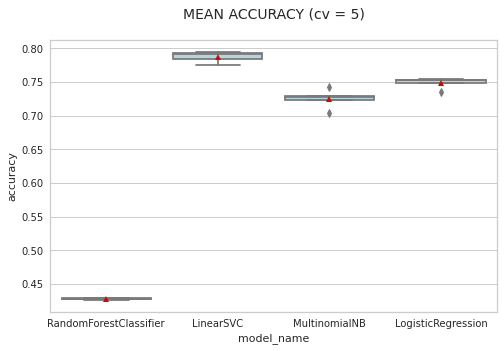

In [96]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_dataframe, 
            color='orange', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);


In [97]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               short_dataframe.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [98]:
y_test = y_test.reset_index(drop=True)
y_test, y_pred

(0       1
 1       0
 2       2
 3       2
 4       1
        ..
 7235    1
 7236    0
 7237    1
 7238    0
 7239    1
 Name: Sentiment_target, Length: 7240, dtype: int64,
 array([1, 1, 2, ..., 1, 0, 1]))

In [99]:
len(y_test),len(y_pred)

(7240, 7240)

In [100]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names=['Positive','Negative', 'Neutral']))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    Positive       0.75      0.73      0.74      1967
    Negative       0.78      0.79      0.78      3141
     Neutral       0.79      0.79      0.79      2132

    accuracy                           0.77      7240
   macro avg       0.77      0.77      0.77      7240
weighted avg       0.77      0.77      0.77      7240



## Confusion Matrix

In [101]:
!git clone https://github.com/DTrimarchi10/confusion_matrix

Cloning into 'confusion_matrix'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), done.


In [103]:
from cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [104]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[1440,  402,  125],
       [ 339, 2483,  319],
       [ 144,  303, 1685]])

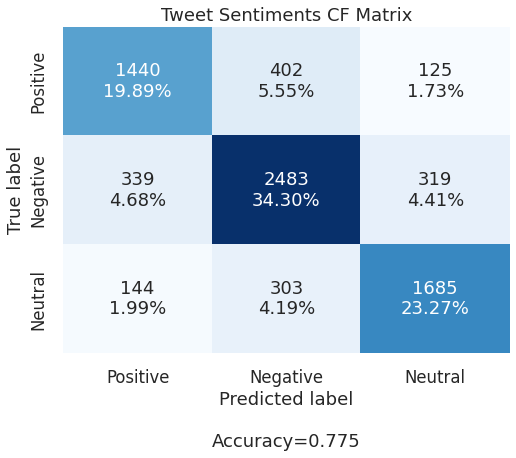

In [105]:
categories = ['Positive','Negative', 'Neutral']
make_confusion_matrix(conf_mat, figsize=(8,6), cbar=False,categories = categories, title='Tweet Sentiments CF Matrix')

## Predictions

In our this Tweet Sentiment Analysis we found that to predict the sentiments Linear SVC Performed better than others with 78% Average accuracy rate.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_dataframe=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [107]:
new_tweet = valid.Tweet[random.randint(0, len(valid.Tweet))]
print(new_tweet)

@PUBG_Support Hiya! So when'll u be fixing your f'n console game? Been asking a lot and have been very satisfied with your lack of responses ☺️ Just wondering if lagouts are a part of the game like red zones and I'm just not aware or if you just can't fix a 2 year + problem. Thx!


In [108]:
model.predict(fitted_vectorizer.transform([new_tweet]))

array([2])

In [109]:
valid[valid['Tweet'] == new_tweet]

,Id,Entity,Sentiment,Tweet,is_train
51,10275,PlayerUnknownsBattlegrounds(PUBG),Negative,@PUBG_Support Hiya! So when'll u be fixing you...,False
